In [1]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download jtiptj/chest-xray-pneumoniacovid19tuberculosis

Dataset URL: https://www.kaggle.com/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis
License(s): other
 99% 1.71G/1.74G [00:16<00:00, 225MB/s]
100% 1.74G/1.74G [00:16<00:00, 110MB/s]


In [ ]:
!unzip /content/chest-xray-pneumoniacovid19tuberculosis.zip -d /content/

In [4]:
#Import all the needed liabraries
import matplotlib.pyplot as plt
from PIL import Image
import random
import os

import tensorflow as tf

from tensorflow.keras import layers,models
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras.utils import plot_model

from sklearn.metrics import confusion_matrix,classification_report,roc_curve,auc
import seaborn as sns

In [5]:
train_dir='/content/train'
val_dir='/content/val'
test_dir='/content/test'

img_width,img_height=224,224
batch_size=32


In [6]:
#Load Dataset
train_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='int',
    image_size=(img_width,img_height),

    batch_size=batch_size
)

Found 6326 files belonging to 4 classes.


In [7]:

val_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode='int',
    image_size=(img_width,img_height),

    batch_size=batch_size
)

Found 38 files belonging to 4 classes.


In [8]:

test_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='int',
    image_size=(img_width,img_height),

    batch_size=batch_size
)

Found 771 files belonging to 4 classes.


In [9]:
#Data Augmentation
data_augmentation=tf.keras.Sequential([

    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),

])

In [10]:
#Apply Data Augmentation On trianing data
train_dataset=train_dataset.map(lambda x,y:(data_augmentation(x,training=True),y))


In [11]:
#Prefetch the data for performance
AUTOTUNE=tf.data.AUTOTUNE # thsi will check how much ram and cpu cores i have and will decide the optimal buffersize
train_dataset=train_dataset.prefetch(buffer_size=AUTOTUNE)# this will create the buffer for training
val_dataset=val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset=test_dataset.prefetch(buffer_size=AUTOTUNE)

In [12]:
def build_VGG16(input_shape=(224,224,3),num_classes=4):
  model=models.Sequential()

  #Add Input Layer
  model.add(layers.Input(shape=input_shape))

  #Add Normalization Layer
  model.add(layers.Rescaling(1./255)),

  #Block1
  model.add(layers.Conv2D(64,(3,3),padding='same',activation='relu')),
  model.add(layers.Conv2D(64,(3,3),padding='same',activation='relu')),
  model.add(layers.MaxPooling2D(pool_size=(2,2),strides=2)),

  #Block2
  model.add(layers.Conv2D(128,(3,3),padding='same',activation='relu')),
  model.add(layers.Conv2D(128,(3,3),padding='same',activation='relu')),
  model.add(layers.MaxPooling2D(pool_size=(2,2),strides=2)),

  #Block3
  model.add(layers.Conv2D(256,(3,3),padding='same',activation='relu')),
  model.add(layers.Conv2D(256,(3,3),padding='same',activation='relu')),
  model.add(layers.Conv2D(256,(3,3),padding='same',activation='relu')),
  model.add(layers.MaxPooling2D(pool_size=(2,2),strides=2)),

  #Block4
  model.add(layers.Conv2D(512,(3,3),padding='same',activation='relu')),
  model.add(layers.Conv2D(512,(3,3),padding='same',activation='relu')),
  model.add(layers.Conv2D(512,(3,3),padding='same',activation='relu')),
  model.add(layers.MaxPooling2D(pool_size=(2,2),strides=2)),

  #Block5
  model.add(layers.Conv2D(512,(3,3),padding='same',activation='relu')),
  model.add(layers.Conv2D(512,(3,3),padding='same',activation='relu')),
  model.add(layers.Conv2D(512,(3,3),padding='same',activation='relu')),
  model.add(layers.MaxPooling2D(pool_size=(2,2),strides=2)),

  #Flatten Layer
  model.add(layers.Flatten()),

  #Dense1
  model.add(layers.Dense(4096,activation='relu')),
  model.add(layers.Dropout(0.5)),

  #Dense2
  model.add(layers.Dense(4096,activation='relu')),
  model.add(layers.Dropout(0.5)),

  #Dense3
  model.add(layers.Dense(num_classes,activation='softmax'))

  return model


In [13]:
model=build_VGG16(input_shape=(img_width,img_height,3),num_classes=4)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │        16,38

 Total params: 134,276,932 (512.23 MB)

 Trainable params: 134,276,932 (512.23 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
history=model.fit(train_dataset,validation_data=val_dataset,epochs=20)

Epoch 1/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 232s 942ms/step - accuracy: 0.5570 - loss: 1.9165 - val_accuracy: 0.2105 - val_loss: 1.8323
Epoch 2/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 133s 670ms/step - accuracy: 0.6086 - loss: 1.0718 - val_accuracy: 0.2105 - val_loss: 1.8152
Epoch 3/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 133s 668ms/step - accuracy: 0.6095 - loss: 1.0637 - val_accuracy: 0.2105 - val_loss: 1.7658
Epoch 4/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 133s 671ms/step - accuracy: 0.6073 - loss: 1.0692 - val_accuracy: 0.2105 - val_loss: 1.8130
Epoch 5/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 132s 667ms/step - accuracy: 0.6087 - loss: 1.0682 - val_accuracy: 0.2105 - val_loss: 1.7986
Epoch 6/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 130s 654ms/step - accuracy: 0.6085 - loss: 1.0674 - val_accuracy: 0.2105 - val_loss: 1.8888
Epoch 7/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 146s 672ms/step - accuracy: 0.6061 - loss: 1.0677 - val_accuracy: 0.2105 - val_loss: 1.7929
Epoch 8/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 130s 656ms/step - accuracy: 0.6104 -

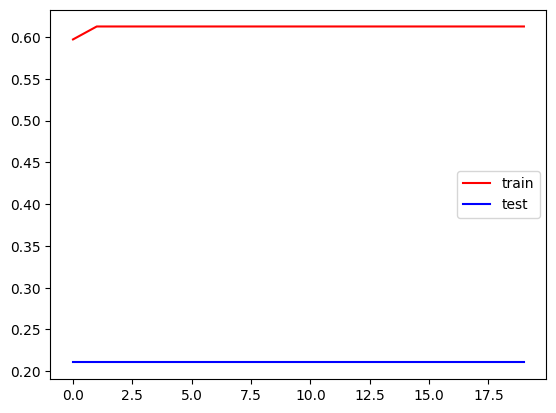

In [16]:

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='test')
plt.legend()
plt.show()

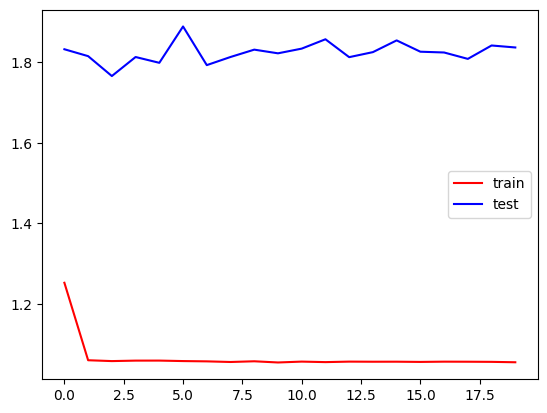

In [17]:

plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='test')
plt.legend()
plt.show()

In [18]:
test_loss,test_accuracy=model.evaluate(test_dataset)
print(f"test accuracy: {test_accuracy*100:.2f}%")

25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 368ms/step - accuracy: 0.5154 - loss: 1.1708
test accuracy: 50.58%


In [19]:
#Train Set Predictions
y_train_true=np.concatenate([y for x,y in train_dataset],axis=0)
y_train_pred=model.predict(train_dataset)
y_train_pred=np.argmax(y_train_pred,axis=1)

#Test set Predictions
y_test_true=np.concatenate([y for x,y in test_dataset],axis=0)
y_test_pred=model.predict(test_dataset)
y_test_pred=np.argmax(y_test_pred,axis=1)

#val Set Predictions
y_val_true=np.concatenate([y for x,y in val_dataset],axis=0)
"""
this will get the true labels of each image and as our data is present in diff batches np.concatenate will merge the labels of diff batches
"""
y_val_pred=model.predict(val_dataset)# will give the prediction of each image in probabilities for each class like [0.05,0.35,0.50,0.10]
y_val_pred=np.argmax(y_val_pred,axis=1)#will give the class label for each image as of their probabilities like for [0.05,0.35,0.50,0.10] --> class 2

198/198 ━━━━━━━━━━━━━━━━━━━━ 101s 501ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 251ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 466ms/step


In [20]:
from sklearn.metrics import confusion_matrix
cm_train=confusion_matrix(y_train_true,y_train_pred)
cm_val=confusion_matrix(y_val_true,y_val_pred)
cm_test=confusion_matrix(y_test_true,y_test_pred)


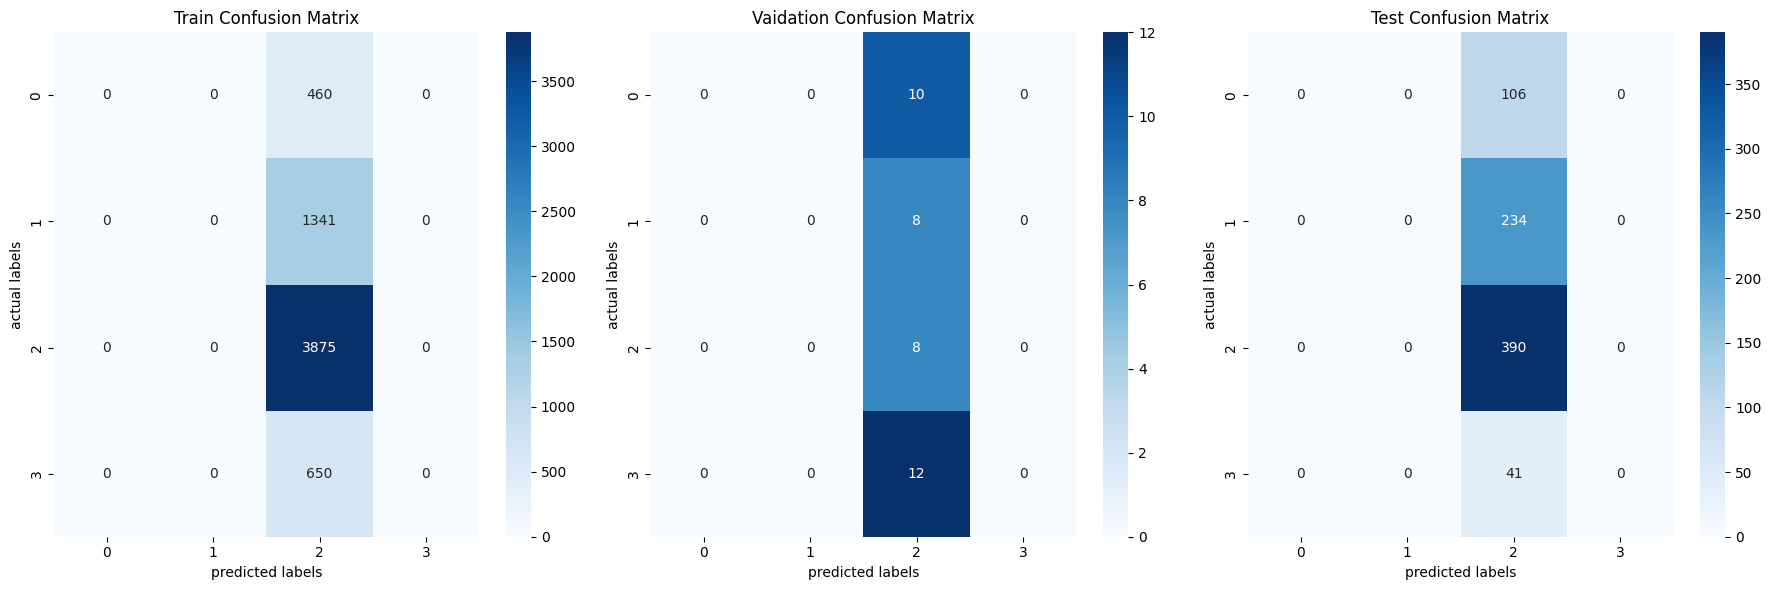

In [21]:
import seaborn as sns

fig,axes=plt.subplots(1,3,figsize=(18,6))

#Train Confusion Matrix
sns.heatmap(cm_train,annot=True,fmt='d',cmap='Blues',ax=axes[0])
axes[0].set_title('Train Confusion Matrix')
axes[0].set_xlabel('predicted labels')
axes[0].set_ylabel('actual labels')

#Vaidation Confusion Matrix
sns.heatmap(cm_val,annot=True,fmt='d',cmap='Blues',ax=axes[1])
axes[1].set_title('Vaidation Confusion Matrix')
axes[1].set_xlabel('predicted labels')
axes[1].set_ylabel('actual labels')

#Test Confusion Matrix
sns.heatmap(cm_test,annot=True,fmt='d',cmap='Blues',ax=axes[2])
axes[2].set_title('Test Confusion Matrix')
axes[2].set_xlabel('predicted labels')
axes[2].set_ylabel('actual labels')

plt.tight_layout()
plt.show()

very bad results as our model is not learning at all.


**Transfer Learning**

In [24]:
#Load VGG16 with pre-trained weights, excluding the top (fully connected layer)
base_model=tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False, # this will exclude the dense layers and will load only convolution layers with the weight of imagenet dataset training
    input_tensor=tf.keras.layers.Input(shape=(img_width,img_height,3))
)
base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
#Freeze the convolution layers
for layer in base_model.layers:
  layer.trainable=False

In [26]:
#Build the Model
model=tf.keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4,activation='softmax')
])

In [27]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562,308 (105.14 MB)

 Trainable params: 12,847,620 (49.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [28]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])

In [29]:
history=model.fit(train_dataset,validation_data=val_dataset,epochs=10)

Epoch 1/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 95s 454ms/step - accuracy: 0.7567 - loss: 4.1405 - val_accuracy: 0.8947 - val_loss: 0.6259
Epoch 2/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 135s 433ms/step - accuracy: 0.8898 - loss: 0.6600 - val_accuracy: 0.7368 - val_loss: 1.6583
Epoch 3/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 86s 432ms/step - accuracy: 0.9136 - loss: 0.3775 - val_accuracy: 0.8684 - val_loss: 0.5591
Epoch 4/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 85s 426ms/step - accuracy: 0.9180 - loss: 0.2749 - val_accuracy: 0.8158 - val_loss: 1.2743
Epoch 5/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 84s 424ms/step - accuracy: 0.9254 - loss: 0.2723 - val_accuracy: 0.8421 - val_loss: 0.4987
Epoch 6/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 103s 520ms/step - accuracy: 0.9282 - loss: 0.2232 - val_accuracy: 0.7632 - val_loss: 0.9585
Epoch 7/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 145s 538ms/step - accuracy: 0.9336 - loss: 0.2205 - val_accuracy: 0.8947 - val_loss: 0.3845
Epoch 8/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 141s 532ms/step - accuracy: 0.9388 - los

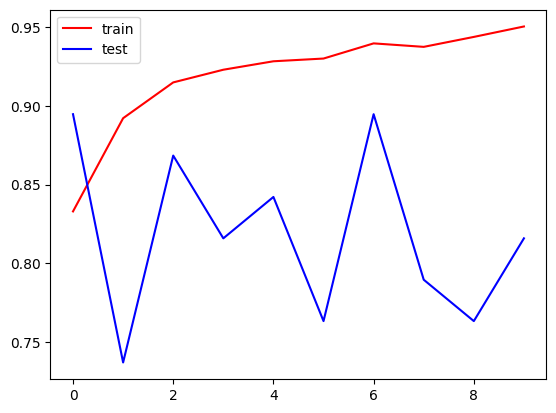

In [30]:

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='test')
plt.legend()
plt.show()

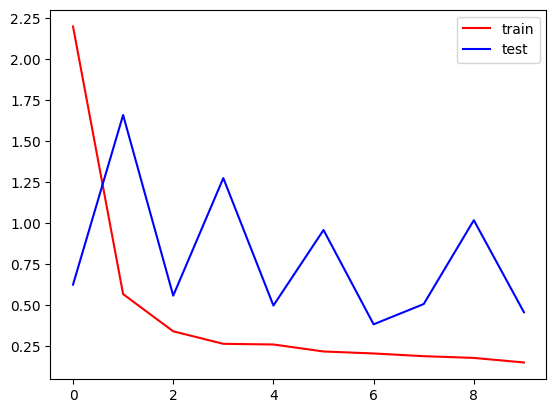

In [31]:

plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='test')
plt.legend()
plt.show()

In [32]:
test_loss,test_accuracy=model.evaluate(test_dataset)
print(f"test accuracy: {test_accuracy*100:.2f}%")

25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 261ms/step - accuracy: 0.8534 - loss: 0.5472
test accuracy: 84.31%


In [33]:
#Train Set Predictions
y_train_true=np.concatenate([y for x,y in train_dataset],axis=0)
y_train_pred=model.predict(train_dataset)
y_train_pred=np.argmax(y_train_pred,axis=1)

#Test set Predictions
y_test_true=np.concatenate([y for x,y in test_dataset],axis=0)
y_test_pred=model.predict(test_dataset)
y_test_pred=np.argmax(y_test_pred,axis=1)

#val Set Predictions
y_val_true=np.concatenate([y for x,y in val_dataset],axis=0)
"""
this will get the true labels of each image and as our data is present in diff batches np.concatenate will merge the labels of diff batches
"""
y_val_pred=model.predict(val_dataset)# will give the prediction of each image in probabilities for each class like [0.05,0.35,0.50,0.10]
y_val_pred=np.argmax(y_val_pred,axis=1)#will give the class label for each image as of their probabilities like for [0.05,0.35,0.50,0.10] --> class 2

198/198 ━━━━━━━━━━━━━━━━━━━━ 91s 452ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step


In [34]:
from sklearn.metrics import confusion_matrix
cm_train=confusion_matrix(y_train_true,y_train_pred)
cm_val=confusion_matrix(y_val_true,y_val_pred)
cm_test=confusion_matrix(y_test_true,y_test_pred)


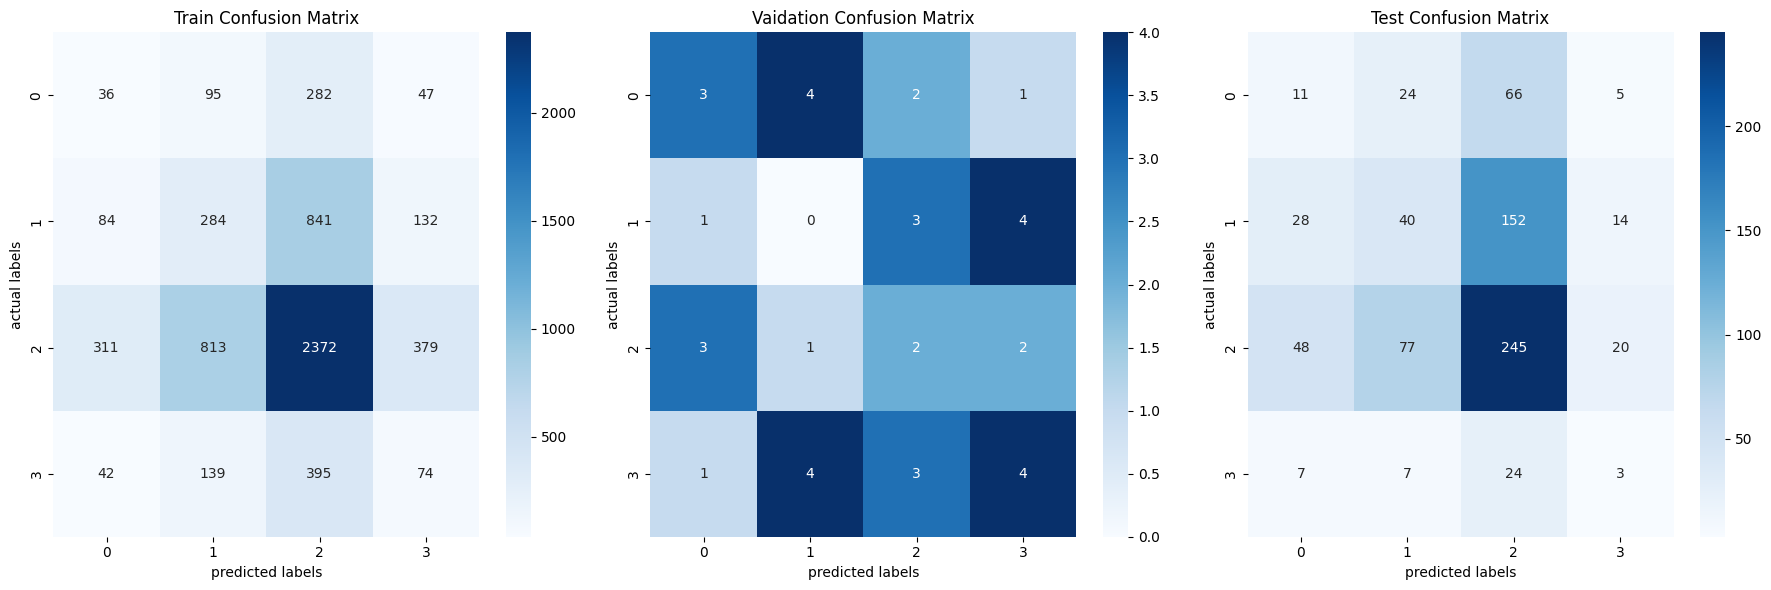

In [35]:
import seaborn as sns

fig,axes=plt.subplots(1,3,figsize=(18,6))

#Train Confusion Matrix
sns.heatmap(cm_train,annot=True,fmt='d',cmap='Blues',ax=axes[0])
axes[0].set_title('Train Confusion Matrix')
axes[0].set_xlabel('predicted labels')
axes[0].set_ylabel('actual labels')

#Vaidation Confusion Matrix
sns.heatmap(cm_val,annot=True,fmt='d',cmap='Blues',ax=axes[1])
axes[1].set_title('Vaidation Confusion Matrix')
axes[1].set_xlabel('predicted labels')
axes[1].set_ylabel('actual labels')

#Test Confusion Matrix
sns.heatmap(cm_test,annot=True,fmt='d',cmap='Blues',ax=axes[2])
axes[2].set_title('Test Confusion Matrix')
axes[2].set_xlabel('predicted labels')
axes[2].set_ylabel('actual labels')

plt.tight_layout()
plt.show()

In [36]:
#Still not very good results

**Transfer learning with Fine Tuning**

In [46]:
#Load the VGG16 Model with trained weights(Imagenet)
base_model=tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_tensor=tf.keras.layers.Input(shape=(img_width,img_height,3))
)

In [47]:
#freeze last 13 layers
to_train=False
count=1
for layer in base_model.layers:
  if count>13:
    to_train=True
  layer.trainable=to_train
  count+=1

In [48]:
#Build the Model
model=tf.keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4,activation='softmax')
])

In [49]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562,308 (105.14 MB)

 Trainable params: 22,286,852 (85.02 MB)

 Non-trainable params: 5,275,456 (20.12 MB)

In [50]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])

In [51]:
history=model.fit(train_dataset,validation_data=val_dataset,epochs=10)

Epoch 1/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 98s 471ms/step - accuracy: 0.7171 - loss: 1.4055 - val_accuracy: 0.6579 - val_loss: 1.0556
Epoch 2/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 89s 448ms/step - accuracy: 0.8943 - loss: 0.3019 - val_accuracy: 0.7632 - val_loss: 0.5094
Epoch 3/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 90s 452ms/step - accuracy: 0.9347 - loss: 0.1882 - val_accuracy: 0.8158 - val_loss: 0.6302
Epoch 4/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 89s 446ms/step - accuracy: 0.9524 - loss: 0.1647 - val_accuracy: 0.9474 - val_loss: 0.2071
Epoch 5/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 90s 449ms/step - accuracy: 0.9571 - loss: 0.1348 - val_accuracy: 0.8421 - val_loss: 0.3387
Epoch 6/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 89s 449ms/step - accuracy: 0.9615 - loss: 0.1034 - val_accuracy: 0.9211 - val_loss: 0.2139
Epoch 7/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 89s 450ms/step - accuracy: 0.9602 - loss: 0.1287 - val_accuracy: 0.7895 - val_loss: 0.5349
Epoch 8/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 142s 449ms/step - accuracy: 0.9687 - loss: 

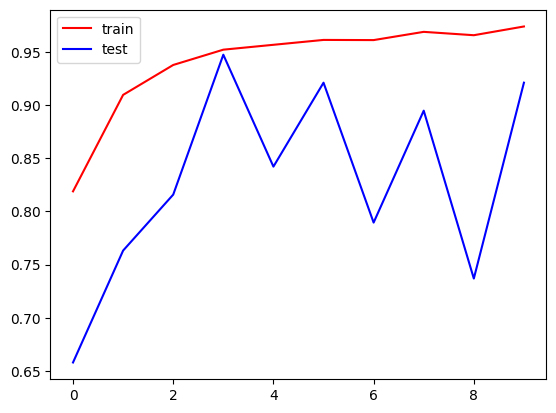

In [52]:

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='test')
plt.legend()
plt.show()

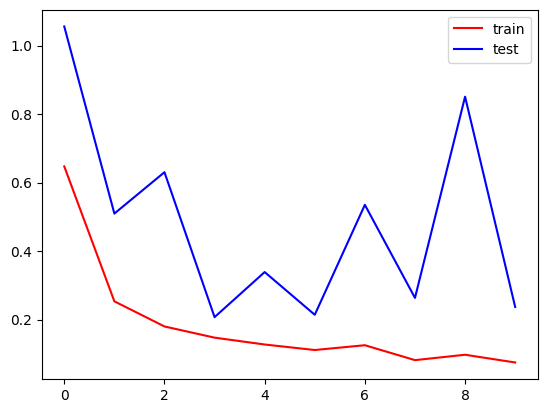

In [53]:

plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='test')
plt.legend()
plt.show()

In [54]:
test_loss,test_accuracy=model.evaluate(test_dataset)
print(f"test accuracy: {test_accuracy*100:.2f}%")

25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 265ms/step - accuracy: 0.8275 - loss: 0.7253
test accuracy: 81.71%


In [55]:
#Train Set Predictions
y_train_true=np.concatenate([y for x,y in train_dataset],axis=0)
y_train_pred=model.predict(train_dataset)
y_train_pred=np.argmax(y_train_pred,axis=1)

#Test set Predictions
y_test_true=np.concatenate([y for x,y in test_dataset],axis=0)
y_test_pred=model.predict(test_dataset)
y_test_pred=np.argmax(y_test_pred,axis=1)

#val Set Predictions
y_val_true=np.concatenate([y for x,y in val_dataset],axis=0)
"""
this will get the true labels of each image and as our data is present in diff batches np.concatenate will merge the labels of diff batches
"""
y_val_pred=model.predict(val_dataset)# will give the prediction of each image in probabilities for each class like [0.05,0.35,0.50,0.10]
y_val_pred=np.argmax(y_val_pred,axis=1)#will give the class label for each image as of their probabilities like for [0.05,0.35,0.50,0.10] --> class 2

198/198 ━━━━━━━━━━━━━━━━━━━━ 91s 454ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 260ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 441ms/step


In [56]:
from sklearn.metrics import confusion_matrix
cm_train=confusion_matrix(y_train_true,y_train_pred)
cm_val=confusion_matrix(y_val_true,y_val_pred)
cm_test=confusion_matrix(y_test_true,y_test_pred)


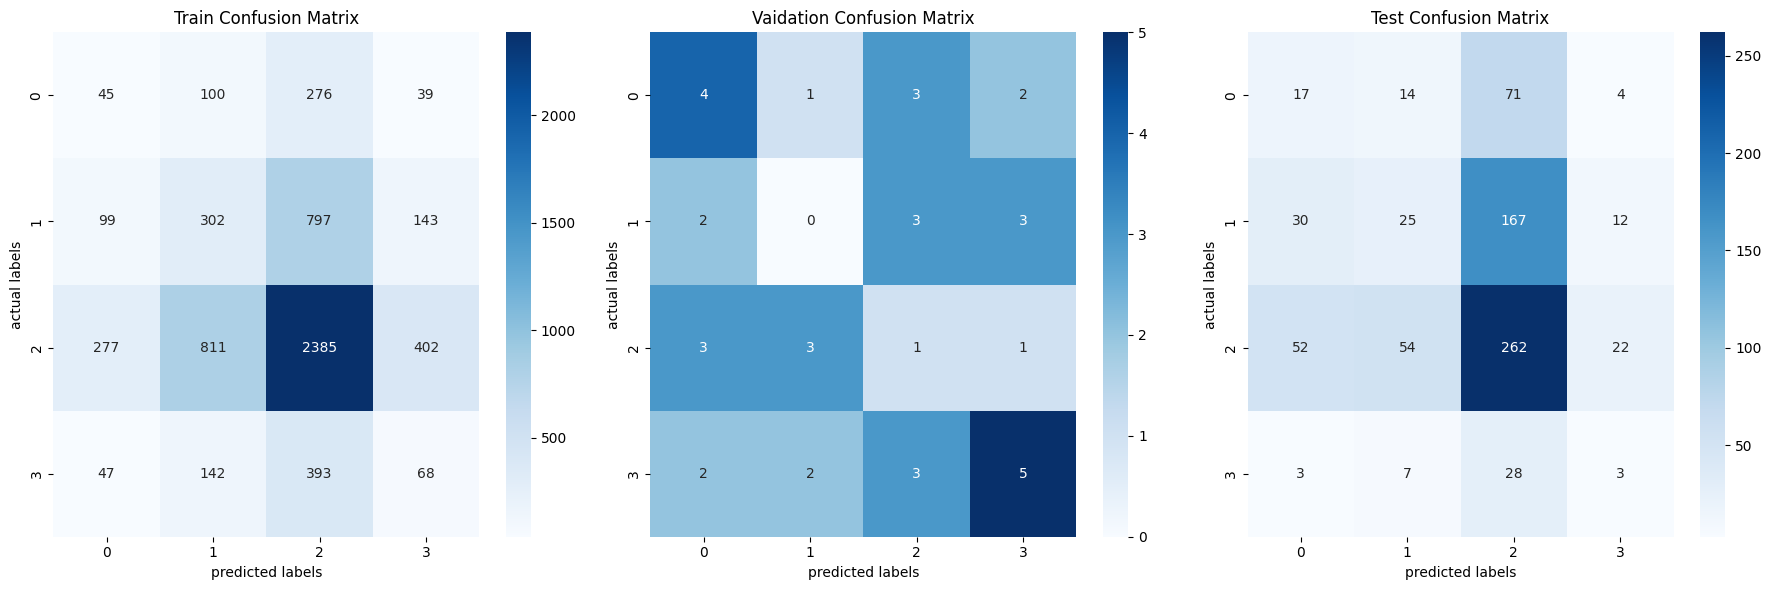

In [57]:
import seaborn as sns

fig,axes=plt.subplots(1,3,figsize=(18,6))

#Train Confusion Matrix
sns.heatmap(cm_train,annot=True,fmt='d',cmap='Blues',ax=axes[0])
axes[0].set_title('Train Confusion Matrix')
axes[0].set_xlabel('predicted labels')
axes[0].set_ylabel('actual labels')

#Vaidation Confusion Matrix
sns.heatmap(cm_val,annot=True,fmt='d',cmap='Blues',ax=axes[1])
axes[1].set_title('Vaidation Confusion Matrix')
axes[1].set_xlabel('predicted labels')
axes[1].set_ylabel('actual labels')

#Test Confusion Matrix
sns.heatmap(cm_test,annot=True,fmt='d',cmap='Blues',ax=axes[2])
axes[2].set_title('Test Confusion Matrix')
axes[2].set_xlabel('predicted labels')
axes[2].set_ylabel('actual labels')

plt.tight_layout()
plt.show()